# Future Forecasting Analysis
## Credit Card Fraud Detection

This notebook performs time series forecasting to predict future fraud trends.


In [1]:
# Import necessary libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(str(Path('..')))
from src.data_loader import DataLoader

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline


## 1. Load Cleaned Data


In [2]:
# Load cleaned data
data_loader = DataLoader(data_dir='../data')
cleaned_csv_path = Path('../data/creditcard_cleaned.csv')

if cleaned_csv_path.exists():
    print(f"✓ Loading cleaned data from: {cleaned_csv_path.absolute()}")
    df = pd.read_csv(cleaned_csv_path)
    print(f"  - Cleaned dataset: {len(df):,} transactions")
else:
    print("Loading original data...")
    df = data_loader.load_csv_data('creditcard.csv')
    df = df.drop_duplicates(keep='first')

print(f"\nDataset shape: {df.shape}")


✓ Loading cleaned data from: d:\h\Financial Fraud Detection-AI\transactions\notebooks\..\data\creditcard_cleaned.csv
  - Cleaned dataset: 283,726 transactions

Dataset shape: (283726, 31)


## 2. Time Series Analysis


In [3]:
# Convert Time to days
df['Day_Index'] = (df['Time'] / (3600 * 24)).astype(int)
df['Hour'] = (df['Time'] / 3600) % 24

# Daily fraud statistics
daily_stats = df.groupby('Day_Index')['Class'].agg(['sum', 'count', 'mean'])
daily_stats.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
daily_stats['Fraud_Rate_Pct'] = daily_stats['Fraud_Rate'] * 100

print("Daily Fraud Statistics:")
print("="*50)
print(daily_stats.describe())
print(f"\nTotal days in dataset: {len(daily_stats)}")


Daily Fraud Statistics:
       Fraud_Count    Total_Count  Fraud_Rate  Fraud_Rate_Pct
count     2.000000       2.000000    2.000000        2.000000
mean    236.500000  141863.000000    0.001663        0.166338
std      50.204581    3355.928784    0.000315        0.031455
min     201.000000  139490.000000    0.001441        0.144096
25%     218.750000  140676.500000    0.001552        0.155217
50%     236.500000  141863.000000    0.001663        0.166338
75%     254.250000  143049.500000    0.001775        0.177459
max     272.000000  144236.000000    0.001886        0.188580

Total days in dataset: 2


## 3. Visualize Historical Trends


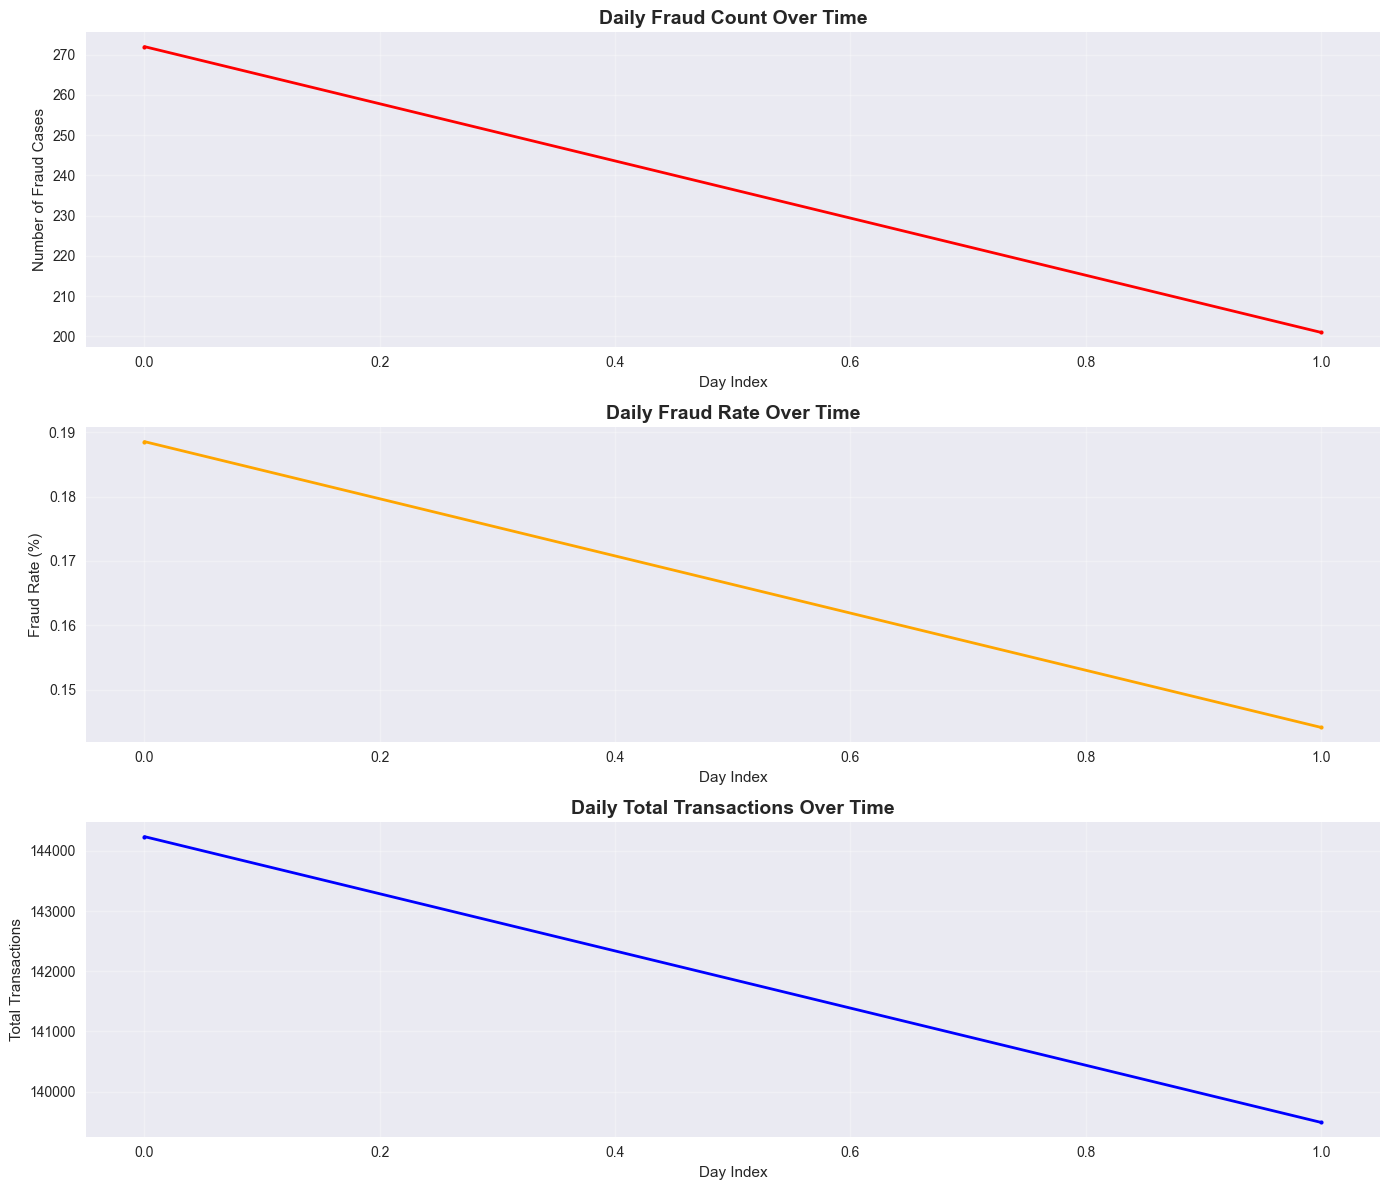

Trends saved to ../reports/forecasting_trends.png


In [4]:
# Plot historical trends
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Fraud count over time
axes[0].plot(daily_stats.index, daily_stats['Fraud_Count'], 
            marker='o', linewidth=2, color='red', markersize=3)
axes[0].set_title('Daily Fraud Count Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day Index')
axes[0].set_ylabel('Number of Fraud Cases')
axes[0].grid(alpha=0.3)

# Fraud rate over time
axes[1].plot(daily_stats.index, daily_stats['Fraud_Rate_Pct'], 
            marker='o', linewidth=2, color='orange', markersize=3)
axes[1].set_title('Daily Fraud Rate Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day Index')
axes[1].set_ylabel('Fraud Rate (%)')
axes[1].grid(alpha=0.3)

# Total transactions over time
axes[2].plot(daily_stats.index, daily_stats['Total_Count'], 
            marker='o', linewidth=2, color='blue', markersize=3)
axes[2].set_title('Daily Total Transactions Over Time', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Day Index')
axes[2].set_ylabel('Total Transactions')
axes[2].grid(alpha=0.3)

plt.tight_layout()
reports_dir = Path('../reports')
reports_dir.mkdir(exist_ok=True)
plt.savefig(reports_dir / 'forecasting_trends.png', dpi=300, bbox_inches='tight')
plt.show()
print("Trends saved to ../reports/forecasting_trends.png")


## 4. Future Predictions (Next 7 Days)


In [5]:
# Simple forecasting using moving average
forecast_days = 7
window = 7

# Use last 7 days average
recent_avg_fraud = daily_stats['Fraud_Count'].tail(window).mean()
recent_avg_rate = daily_stats['Fraud_Rate_Pct'].tail(window).mean()

# Generate forecast
last_day = daily_stats.index.max()
future_days = np.arange(last_day + 1, last_day + forecast_days + 1)

forecast_df = pd.DataFrame({
    'Day_Index': future_days,
    'Predicted_Fraud_Count': [recent_avg_fraud] * forecast_days,
    'Predicted_Fraud_Rate': [recent_avg_rate] * forecast_days
})

print("Future Forecast (Next 7 Days):")
print("="*50)
print(forecast_df.to_string(index=False))

# Save forecast
forecast_df.to_csv(reports_dir / 'future_forecast.csv', index=False)
print("\nForecast saved to ../reports/future_forecast.csv")


Future Forecast (Next 7 Days):
 Day_Index  Predicted_Fraud_Count  Predicted_Fraud_Rate
         2                  236.5              0.166338
         3                  236.5              0.166338
         4                  236.5              0.166338
         5                  236.5              0.166338
         6                  236.5              0.166338
         7                  236.5              0.166338
         8                  236.5              0.166338

Forecast saved to ../reports/future_forecast.csv


## 5. Visualize Forecast


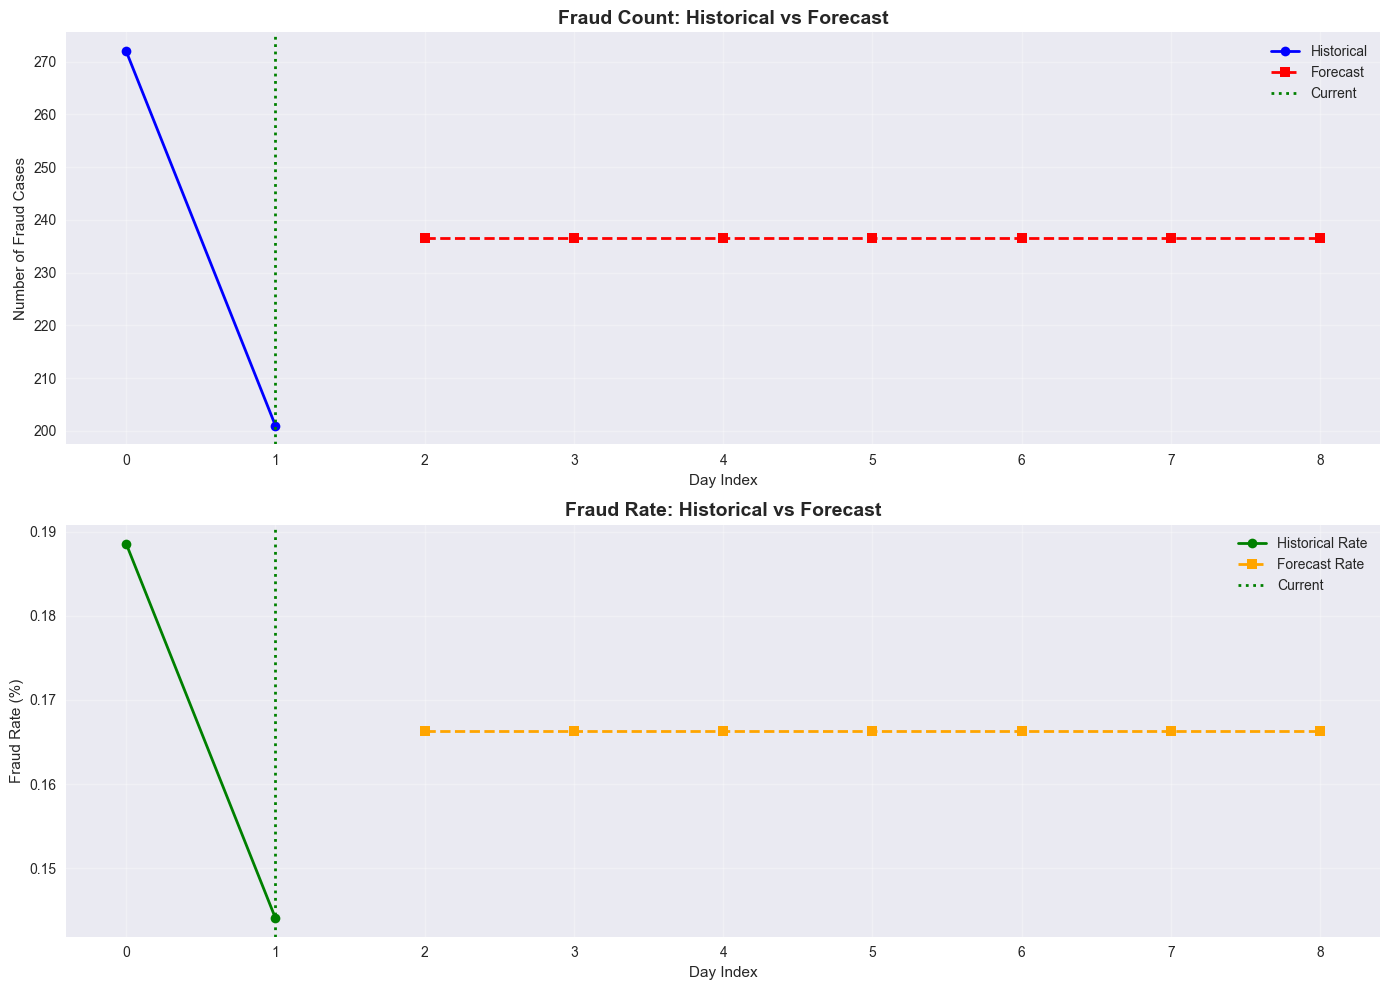

Forecast visualization saved to ../reports/forecast_visualization.png


In [6]:
# Plot historical + forecast
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Fraud count
recent_days = daily_stats.tail(30)
axes[0].plot(recent_days.index, recent_days['Fraud_Count'], 
            marker='o', linewidth=2, label='Historical', color='blue')
axes[0].plot(forecast_df['Day_Index'], forecast_df['Predicted_Fraud_Count'], 
            marker='s', linewidth=2, linestyle='--', label='Forecast', color='red')
axes[0].axvline(x=last_day, color='green', linestyle=':', linewidth=2, label='Current')
axes[0].set_title('Fraud Count: Historical vs Forecast', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day Index')
axes[0].set_ylabel('Number of Fraud Cases')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Fraud rate
axes[1].plot(recent_days.index, recent_days['Fraud_Rate_Pct'], 
            marker='o', linewidth=2, label='Historical Rate', color='green')
axes[1].plot(forecast_df['Day_Index'], forecast_df['Predicted_Fraud_Rate'], 
            marker='s', linewidth=2, linestyle='--', label='Forecast Rate', color='orange')
axes[1].axvline(x=last_day, color='green', linestyle=':', linewidth=2, label='Current')
axes[1].set_title('Fraud Rate: Historical vs Forecast', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day Index')
axes[1].set_ylabel('Fraud Rate (%)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(reports_dir / 'forecast_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("Forecast visualization saved to ../reports/forecast_visualization.png")


## 6. Summary


In [7]:
print("="*70)
print("FORECASTING SUMMARY")
print("="*70)
print(f"\n1. Historical Analysis:")
print(f"   - Total days analyzed: {len(daily_stats)}")
print(f"   - Average daily fraud: {daily_stats['Fraud_Count'].mean():.2f}")
print(f"   - Average fraud rate: {daily_stats['Fraud_Rate_Pct'].mean():.3f}%")
print(f"\n2. Future Predictions (Next {forecast_days} Days):")
print(f"   - Average predicted fraud: {forecast_df['Predicted_Fraud_Count'].mean():.2f} per day")
print(f"   - Total predicted fraud: {forecast_df['Predicted_Fraud_Count'].sum():.0f}")
print(f"   - Average predicted rate: {forecast_df['Predicted_Fraud_Rate'].mean():.3f}%")
print(f"\n3. Reports Generated:")
print(f"   - ../reports/forecasting_trends.png")
print(f"   - ../reports/forecast_visualization.png")
print(f"   - ../reports/future_forecast.csv")
print("="*70)


FORECASTING SUMMARY

1. Historical Analysis:
   - Total days analyzed: 2
   - Average daily fraud: 236.50
   - Average fraud rate: 0.166%

2. Future Predictions (Next 7 Days):
   - Average predicted fraud: 236.50 per day
   - Total predicted fraud: 1656
   - Average predicted rate: 0.166%

3. Reports Generated:
   - ../reports/forecasting_trends.png
   - ../reports/forecast_visualization.png
   - ../reports/future_forecast.csv
